*Run this before all other cells*

In [1]:
import geopandas as gp
import pandas as pd
import ipyleaflet as ip
from ipywidgets import Text, HTML
import ee
import geemap as gm
import datetime as dt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Authenticate with Google Earth Engine credentials
#ee.Authenticate(force=True)

# Initialise with your own Google Cloud project
ee.Initialize()

/home/chaitanya/esa/env/lib/python3.13/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Exploration of land-cover changes in the Protected Areas and buffer zones of Goa's wildlife sanctuaries and national parks

This exploration was done in Python using the following packages and libraries:

- geopandas
- matplotlib
- pandas
- ee
- geemap

I used the interactive shell IPython as it allows for a richer visual experience and provides methods for previewing maps and graphs.

Data is drawn from:

- _Who made the PA polygons?_
- [The SHRUG](https://www.devdatalab.org/shrug)
- [Global 30-meter Land Cover Change Dataset (1985-2022) - (GLC_FCS30D)](https://gee-community-catalog.org/projects/glc_fcs/)

## Data preparation methods

### 1 - Protected area, buffer & village/town polygons

#### 1.1 - Protected area & buffer polygons

In order to capture meaningful land cover changes we first need to create useful polygons to define areas of interest. I started with the shapefile "Notified_PA_Goa" created by \_\_\_\_ for each of the 7 notified protected areas:

1. Mhadei Wildlife Sanctuary
2. Bhagwan Mahavir Wildlife Sanctuary (N)\*
3. Mollem National Park
4. Bhagwan Mahavir Wildlife Sanctuary (S)\*
5. Bondla Wildlife Sacntuary
6. Netravali Wildlife Sanctuary
7. Cotigaon Wildlife Sanctuary
8. Dr. Salim Ali Wildlife Sanctuary

\* as per the shapefile Bhagwan Mahavir Wildlife Sanctuary is made up of 2 non-contiguous polygons. They will be treated independently for this analysis.

In order to consistently reference a single polygon the "Name" column of the dataset needs to be unique.

Since all the areas of interest lie within the state of Goa, I have chosen to use the coordinate reference system [EPSG:7779](https://spatialreference.org/ref/epsg/7779/).

The "geometry" column represents the boundaries of the PAs not including the 1,000 m buffers. Therefore, the buffers would be the set of polygons extending from the current geometry columns outward 1,000 m. The polygons include a Z axis which is not relevant for the current analysis.

These buffers do not take into account the fact that most of the PAs are contiguous and along Goa's eastern border. The buffers overlap each other, other PAs or fall outside the state. They need to be clipped to account for these inconsistencies. Because of minor misalignments between the polygons representing each PA and the polygon representing the state, there are artifacts left over from the clip. These small areas along the state border and at the points where PAs meet need to be deleted leaving only the single buffer polygon.

The state's boundaries are taken from [the SHRUG](https://www.devdatalab.org/shrug) and preprocessed to include only the polygon representing Goa and have been reprojected into [EPSG:7779](https://spatialreference.org/ref/epsg/7779/).

This data set is saved as "pas.feather" and "buffers.feather".

In [ ]:
# Read in data
pas = gp.read_file('data/Goa_protected_areas/Notified_PA_Goa.shp')
state = gp.read_feather('feathers/admin_units/state.feather')

# Clean up columns and names
pas = pas.drop(columns=['Shape_Leng', 'Shape_Area'])
pas = pas.rename(columns={'Name': 'name'})

# Use index values to make Pa names unique and reset index
pas = pas.reset_index()
pas['index'] = pas['index'].astype(str)
pas['name'] = pas['index'] + '_' + pas['name'].str.replace(' ', '_').str.replace('.', '')
pas = pas.drop(columns=['index'])
pas = pas.set_index('name')

# Make 2D
pas.geometry = pas.force_2d()

# Reproject to correct CRS
pas = pas.to_crs('EPSG:7779')

# Create polygons 1,000m larger in all directions
buffers = gp.GeoDataFrame(pas.buffer(1000)).rename(columns={0:'geometry'}).set_geometry('geometry')

# Subtract PA from the new buffer polygon
buffers.geometry = buffers.difference(pas)

# Keep only parts of the buffers inside the state
buffers.geometry = buffers.intersection(state.loc['30', 'geometry'])

# Subtract each PA from all buffers
pa_polygon_list = eszs['pa'].to_list()

for pa_polygon in pa_polygon_list:
    buffers.geometry = buffers.difference(pa_polygon)

# Delete artifacts of misalignment between PAs, state boundary, etc.
buffer_parts = buffers.explode(index_parts=True)
buffer_parts['part_area'] = buffer_parts.area

# For each buffer, sort descending by area, keep largest only
buffers = buffer_parts.sort_values(['name', 'part_area'], ascending=False).groupby('name').first().drop(columns=['part_area']).set_geometry('geometry').set_crs('EPSG:7779')

# Uncomment below to save the dataset
#pas.to_feather('feathers/pas.feather')
#buffers.to_feather('feathers/buffers.feather')

**ISSUE** The buffers also intersect with themselves. For any analysis done on a per-PA basis this will not have an impact. However, any analysis done on a state-wide basis will include some double counting for the area within the intersection of the buffers.

### 1.2 - Village/town polygons

Village/town polygons are taken from [the SHRUG](https://www.devdatalab.org/shrug). The dataset consists of the subset of villages/towns that intersect with either a PA or a buffer. The dataset has already been reprojected to [EPSG:7779](https://spatialreference.org/ref/epsg/7779/).

From here on lets refer to them as admin. units.

**ISSUE** I have no idea what the "mdds_og" column in the SHRUG town/village shapefiles is for.

Each admin. unit needs to be linked to a specific PA or buffer and, its area clipped to only the part that overlaps with that PA or buffer. Some admin. units appear in the final dataset multiple times because they intersect with multiple PAs and/or buffers.

The dataset is indexed at the following levels:

1. ESZ name - e.g. 0_Mhadei_WLS
2. ESZ part - either "pa" or "buffer"
3. Political Census of India 2011 state ID
4. Political Census of India 2011 district ID EPSG:7779
5. Political Census of India 2011 subdistrict ID
6. Political Census of India 2011 town/village ID
7. Name of the town/village

The dataset is saved as "clipped_villages.feather".

In [ ]:
# Read in data
pas = gp.read_feather('feathers/pas.feather')
buffers = gp.read_feather('feathers/buffers.feather')
villages = gp.read_feather('feathers/admin_units/villages.feather')

def clip_villages(row, part):
# Create apply function
# For each PA & buffer,
#   clip admin. units that intersect,
#   drop admin. units that do not intersect,
#   add a column showing whether the admin. unit
#   intersects with a PA or a buffer and
#   add another column showing which one.
# Reindex and add to list.

    gdf = villages.copy()
    gdf.geometry = gdf.intersection(row.geometry)
    gdf = gdf[~(gdf['geometry'].is_empty | gdf['geometry'].isna())]
    gdf['esz'] = row.name
    gdf['part'] = part
    idx = ['esz', 'part'] + gdf.index.names
    gdf = gdf.reset_index()
    gdf = gdf.set_index(idx)
    gdfs.append(gdf)

gdfs = []
pas.apply(clip_villages, axis=1, args=('pa',))
buffers.apply(clip_villages, axis=1, args=('buffer',))

# Concatenate all the GeoDataFrames together
clipped_villages = pd.concat(gdfs)

# Uncomment below to save the dataset
#clipped_villages.to_feather('feathers/clipped_villages.feather')

#### 1.3 - Maps

Mapping the clipped admin. over their respective PAs and buffers gives the following interactive map. Each ESZ can be shown or hidden along with those admin. units that intersect with it.

In [ ]:
# Read in data in degree crs
state = gp.read_feather('feathers/admin_units/state.feather').to_crs("EPSG:4326")
clipped_villages = gp.read_feather('feathers/clipped_villages.feather').to_crs("EPSG:4326")
pas = gp.read_feather('feathers/pas.feather').to_crs("EPSG:4326")
buffers = gp.read_feather('feathers/buffers.feather').to_crs("EPSG:4326")

# Reset village index and columns
clipped_villages = clipped_villages.reset_index().set_index(['esz', 'part', 'name'])
clipped_villages = clipped_villages.drop(columns=['pc11_state_id', 'pc11_district_id', 'pc11_subdistrict_id', 'pc11_town_village_id', 'mdds_og'])

# Select basemaps
positron = ip.basemap_to_tiles(ip.basemaps.CartoDB.PositronNoLabels)
positron.base = True
positron.name = 'CartoDB Positron'

# Add basemap layers
layers = [positron]

# Set center
center = state.representative_point().loc['30']
center = [center.y, center.x]

# Make overlays
state_gd = ip.GeoData(
    geo_dataframe=state,
    style={'color': 'brown', 'weight': 1, 'fill': False, 'opacity': 0.8},
    name='State border'
)

esz_group = clipped_villages.groupby('esz')

# Show ESZ name, part and village name on hover
def update_html_village(feature, **kwargs):
    id = feature['id'].split(', ')
    
    esz = ' '.join(id[0][2:-1].split('_'))
    village = id[2][1:-2]
    if 'pa' in id[1]:
        esz += ' PA'
    else:
        esz += ' buffer'
    html.value = """
        <h3><b>{}</b></h3>
        <h4>Village: {}</h4>
    """.format(
        esz,
        village,
    )

def update_html_pa(feature, **kwargs):
    html.value = """
        <h3><b>{}</b></h3>
    """.format(
        ' '.join(feature['id'].split('_')) + ' PA',
    )

def update_html_buffer(feature, **kwargs):
    html.value = """
        <h3><b>{}</b></h3>
    """.format(
        ' '.join(feature['id'].split('_')) + ' buffer',
    )
    
# For each group of villages and each corresponding ESZ part,
# create a layer
for name, group in esz_group:
    title = ' '.join(name.split('_'))
    part_group = group.groupby('part')

    pa = ip.GeoData(
        geo_dataframe=pas.loc[[name]],
        style={'color': 'green',
               'weight': 1,
               'fillOpacity': 0.2},
        hover_style={'color': 'green',
               'weight': 1,
               'fillOpacity': 0.6},
        name=title + " PA",
    )
    pa.on_hover(update_html_pa)
    layers.append(pa)
    
    pa_villages = ip.GeoData(
        geo_dataframe=part_group.get_group('pa'),
        style={'color': 'black',
               'weight': 1,
               'fillOpacity': 0,
               'opacity': 0.2},
        hover_style={'color': 'black',
               'weight': 1,
               'fillColor': 'green',
               'fillOpacity': 0.4,
               'opacity': 0.8},
        name=title + " PA villages",
    )
    pa_villages.on_hover(update_html_village)
    layers.append(pa_villages)

    buffer = ip.GeoData(
        geo_dataframe=buffers.loc[[name]],
        style={'color': 'blue',
               'weight': 1,
               'fillOpacity': 0.2},
        hover_style={'color': 'blue',
               'weight': 1,
               'fillOpacity': 0.6},
        name=title + " buffer"
    )
    buffer.on_hover(update_html_buffer)
    layers.append(buffer)
    
    buffer_villages = ip.GeoData(
        geo_dataframe=part_group.get_group('buffer'),
        style={'color': 'black',
               'weight': 1,
               'fillOpacity': 0,
               'opacity': 0.2},
        hover_style={'color': 'black',
               'weight': 1,
               'fillColor': 'blue',
               'fillOpacity': 0.4,
               'opacity': 0.8},
        name=title + " buffer villages",
    )
    buffer_villages.on_hover(update_html_village)
    layers.append(buffer_villages)

layers.append(state_gd)

# Make map
m = ip.Map(layers=layers,
           center=center,
           zoom=9,
           scroll_wheel_zoom=True)

# Add controls and name display window
html = HTML("""Hover over a shape""")
html.layout.margin = "0px 20px 20px 20px"
control = ip.WidgetControl(widget=html, position="topright")
m.add(control)

m.add(ip.LayersControl(position='topleft'))
m.add(ip.FullScreenControl(position='bottomleft'))

# Show map
display(m)

### 2 - Land-cover data

Land-cover data is drawn from the [Global 30-meter Land Cover Change Dataset (1985-2022) - (GLC_FCS30D)](https://gee-community-catalog.org/projects/glc_fcs/). More information on it and the land-cover types used can be found in the paper [GLC_FCS30D: the first global 30 m land-cover dynamics monitoring product with a fine classification system for the period from 1985 to 2022 generated using dense-time-series Landsat imagery and the continuous change-detection method](https://essd.copernicus.org/articles/16/1353/2024/).

The dataset is divided into 2 sections: the annual section containing annual data from 2000 to 2022, and the five-yearly section with five-yearly data from 1985 to 1995.

The sections are Google Earth Engine image collections containing 2 images each, divided geographically. Each band in each section represents an annual/five-yearly dataset. Therefore, the five-yearly set has 3 bands and the annual has 23. Each pixel represents a 30x30 m area and is coded with 1 of the land-cover types as described in the paper above.

The land-cover types, their IDs, descriptive names and colour codes are stored in the "GLC_FCS30D_land_cover_types.feather" dataset.

In [ ]:
# Read in data in degree crs
state = gp.read_feather('feathers/admin_units/state.feather').to_crs("EPSG:4326")
lc_types = pd.read_feather('feathers/GLC_FCS30D_landcover_types.feather')
clipped_villages = gp.read_feather('feathers/clipped_villages.feather').to_crs("EPSG:4326")
pas = gp.read_feather('feathers/pas.feather').to_crs("EPSG:4326")
buffers = gp.read_feather('feathers/buffers.feather').to_crs("EPSG:4326")

fine_lc = lc_types.reset_index()[['fine_id', 'fine_classification_system', 'fine_color']].set_index('fine_id')

clipped_villages = clipped_villages.reset_index().set_index(['esz', 'part', 'name'])
clipped_villages = clipped_villages.drop(columns=['pc11_state_id', 'pc11_district_id', 'pc11_subdistrict_id', 'pc11_town_village_id', 'mdds_og'])

# Set center
center = state.representative_point().loc['30']
center = [center.y, center.x]

# Create palette
colors = fine_lc['fine_color'].to_list()
palette = ['#{:02x}{:02x}{:02x}'.format(int(c[0]), int(c[1]), int(c[2])) for c in colors]

# Create legend names
names = fine_lc['fine_classification_system'].to_list()
legend_dict = dict(zip(names, palette))

esz_group = clipped_villages.groupby('esz')

# Show ESZ name, part and village name on hover
def update_html_village(feature, **kwargs):
    id = feature['id'].split(', ')
    
    esz = ' '.join(id[0][2:-1].split('_'))
    village = id[2][1:-2]
    if 'pa' in id[1]:
        esz += ' PA'
    else:
        esz += ' buffer'
    html.value = """
        <h3><b>{}</b></h3>
        <h4>Village: {}</h4>
    """.format(
        esz,
        village,
    )

def update_html_pa(feature, **kwargs):
    html.value = """
        <h3><b>{}</b></h3>
    """.format(
        ' '.join(feature['id'].split('_')) + ' PA',
    )

def update_html_buffer(feature, **kwargs):
    html.value = """
        <h3><b>{}</b></h3>
    """.format(
        ' '.join(feature['id'].split('_')) + ' buffer',
    )
    
# For each group of villages and each corresponding ESZ part,
# create a layer
layers = []

for name, group in esz_group:
    title = ' '.join(name.split('_'))
    part_group = group.groupby('part')

    pa = ip.GeoData(
        geo_dataframe=pas.loc[[name]],
        style={'color': 'pink',
               'weight': 2,
               'fillOpacity': 0},
        hover_style={'color': 'black',
               'weight': 2,
               'opacity': 0.8},
        name=title + " PA",
    )
    pa.on_hover(update_html_pa)
    layers.append(pa)
    
    pa_villages = ip.GeoData(
        geo_dataframe=part_group.get_group('pa'),
        style={'color': 'black',
               'weight': 2,
               'fillOpacity': 0,
               'opacity': 0.2},
        hover_style={'color': 'black',
               'weight': 2,
               'opacity': 0.8},
        name=title + " PA villages",
    )
    pa_villages.on_hover(update_html_village)
    layers.append(pa_villages)

    buffer = ip.GeoData(
        geo_dataframe=buffers.loc[[name]],
        style={'color': 'yellow',
               'weight': 2,
               'fillOpacity': 0},
        hover_style={'color': 'black',
               'weight': 2,
               'opacity': 0.8},
        name=title + " buffer"
    )
    buffer.on_hover(update_html_buffer)
    layers.append(buffer)
    
    buffer_villages = ip.GeoData(
        geo_dataframe=part_group.get_group('buffer'),
        style={'color': 'black',
               'weight': 2,
               'fillOpacity': 0,
               'opacity': 0.2},
        hover_style={'color': 'black',
               'weight': 2,
               'opacity': 0.8},
        name=title + " buffer villages",
    )
    buffer_villages.on_hover(update_html_village)
    layers.append(buffer_villages)

lg = ip.LayerGroup(layers=tuple(layers), name='ESZs, villages')

# Access GLC_FCS30D datasets
glc_annual = ee.ImageCollection('projects/sat-io/open-datasets/GLC-FCS30D/annual')
glc_five_year = ee.ImageCollection('projects/sat-io/open-datasets/GLC-FCS30D/five-years-map')

# Mosaic the 2 images together for each ImageCollection
glc_annual = glc_annual.mosaic()
glc_five_year = glc_five_year.mosaic()

# Rename bands to years
glc_annual = glc_annual.rename(ee.List.sequence(2000, 2022).map(lambda x: ee.Number(x).format('%04d')))
glc_five_year = glc_five_year.rename(ee.List.sequence(1985, 1995, 5).map(lambda x: ee.Number(x).format('%04d')))

# Combine all bands into 1 image
glc_all_years = glc_five_year.addBands(glc_annual)

# Convert geopandas to FeatureCollections
state_fc = gm.gdf_to_ee(state)

# Filter image bounds
glc_clipped = glc_all_years.clipToCollection(state_fc)

m = gm.Map(center=center,
           zoom=9,
           basemap=ip.basemaps.CartoDB.PositronNoLabels,
           lite_mode=True)

#Add layers to map
from_list = list(fine_lc.index)
from_list = [int(s) for s in from_list]

bands = glc_all_years.bandNames().getInfo()

for band in bands:
    reclassed = glc_clipped.select(band).remap(from_list, ee.List.sequence(1, len(from_list)))
    m.addLayer(reclassed, {'palette': palette}, band)

m.addLayer(lg)

for l in m.layers:
    if l.name in bands:
        l.base = True

html = HTML("""Select a layer from layer control
               Hover over a shape""")
html.layout.margin = "0px 20px 20px 20px"
control = ip.WidgetControl(widget=html, position="topright")
m.add(control)

m.add(ip.LayersControl(position='topleft'))
m.add(ip.FullScreenControl(position='bottomleft'))

m.add_legend(legend_title="GLC FCS30D Types", legend_dict=legend_dict)

display(m)

#### 2.1 - Land-cover type frequency

The aggregated dataset is created by taking the frequency of each land-cover type within each admin. unit polygon for each time interval and multiplying it by the resolution (30x30 m). This results in a dataframe with each admin. unit from "clipped_villages.feather" associated with the area in square metres of each land-cover type for each time interval (either five-yearly or annual).

Each admin. unit is indexed by:

1. ESZ name - e.g. 0_Mhadei_WLS
2. ESZ part - either "pa" or "buffer"
3. Political Census of India 2011 town/village ID
4. Name of the admin. unit
5. Year - 1985 to 2000 in 5 year intervals, 2000 to 2022 in 1 year intervals

The admin. units can be linked back to their individual polygons and the polygons for the PAs and buffers using the "clipped_villages.feather" dataset.

Land-cover types are indexed by:

1. Basic ID
2. Level-1 ID
3. Fine ID

These IDs can be linked back to descriptive names using the "GLC_FCS30D_land_cover_types.feather" dataset.

In [ ]:
# Read in data
clipped_villages = gp.read_feather('feathers/clipped_villages.feather')

# Drop unnecessary columns
idx_names = ['esz', 'part', 'pc11_town_village_id', 'name']
clipped_villages = clipped_villages.reset_index()
drops = list(set(clipped_villages.columns.to_list()) - set(idx_names + ['geometry']))
clipped_villages = clipped_villages.drop(columns=drops)

# Convert GeoDataFrame to Earth Engine FeatureCollection
#   Reporject to EPSG:4326, Google Earth Engine's default
village_fc = gm.gdf_to_ee(clipped_villages.to_crs('EPSG:4326'))

# Access GLC_FCS30D 2000 - 2022 annual dataset and
#   filter for area of interest
glc_annual = ee.ImageCollection('projects/sat-io/open-datasets/GLC-FCS30D/annual').filterBounds(village_fc)

# Access GLC_FCS30D 1985 - 1995 five-yearly dataset and
#   filter for area of interest
glc_five_year = ee.ImageCollection('projects/sat-io/open-datasets/GLC-FCS30D/five-years-map').filterBounds(village_fc)

# Mosaic the 2 images together for each ImageCollection
glc_annual = glc_annual.mosaic()
glc_five_year = glc_five_year.mosaic()

# Rename bands to years
glc_annual = glc_annual.rename(ee.List.sequence(2000, 2022).map(lambda x: ee.Number(x).format('%04d')))
glc_five_year = glc_five_year.rename(ee.List.sequence(1985, 1995, 5).map(lambda x: ee.Number(x).format('%04d')))

# Combine all bands into 1 image
glc_all_years = glc_five_year.addBands(glc_annual)

# Get frequency for
#   each land-cover type,
#   for each admin. unit,
#   for each year
lc_data_fc = glc_all_years.reduceRegions(
    collection=village_fc,
    reducer=ee.Reducer.frequencyHistogram(),
    scale=30,
    crs='EPSG:7779')

# Drop all geometries
lc_data_fc = lc_data_fc.select(propertySelectors=['.*'], retainGeometry=False)

# Convert FeatureCollection to DataFrame
lc_data_df = gm.ee_to_df(lc_data_fc)

# Unpivot years from columns to values
lc_data_df = pd.melt(lc_data_df, id_vars=idx_names, var_name='year')

# Spread "value" column dictionary into
#   columns of land-cover types
lc_data_df = pd.concat([lc_data_df, pd.json_normalize(lc_data_df['value'])], axis=1)

# Convert "year" column to datetime
lc_data_df['year'] = pd.to_datetime(lc_data_df['year'], format="%Y")

# Set index
idx_names.append('year')
lc_data_df = lc_data_df.set_index(idx_names)
lc_data_df = lc_data_df.sort_index()

# Sort land-cover type columns
lc_type_cols = lc_data_df.select_dtypes(include='number').columns.to_list()
lc_type_cols = [int(x) for x in lc_type_cols if x != '0']
lc_type_cols.sort()
lc_type_cols = [str(x) for x in lc_type_cols]
lc_type_cols = lc_type_cols + ['0']
lc_data_df = lc_data_df[lc_type_cols]

# Index columns by land-cover type aggregations
lc_types = pd.read_feather('feathers/GLC_FCS30D_landcover_types.feather')
lc_types = lc_types.reset_index()
lc_type_tuples = list(lc_types[['basic_id', 'level_1_id', 'fine_id']].itertuples(index=False, name=None))
lc_type_tuples = [x for x in lc_type_tuples if str(x[2]) in lc_type_cols]
lc_type_tuples = lc_type_tuples + [('XXX', 'XXX', 0)]
lc_data_df.columns = pd.MultiIndex.from_tuples(t for t in lc_type_tuples if str(t[2]) in lc_type_cols)
lc_data_df.columns.names = ['basic_id', 'level_1_id', 'fine_id']

# Separate annual and five-yearly data
annual = lc_data_df.loc[lc_data_df.index.get_level_values('year') > dt.datetime(2000,1,1)]
five_year = lc_data_df.loc[lc_data_df.index.get_level_values('year') <= dt.datetime(2000,1,1)]

# Resample five-yearly data to annual
resampled = five_year.reset_index(idx_names[:-1]).groupby(idx_names[:-1], group_keys=False).resample('YS').first()

# Forward fill index columns
resampled.loc[:,idx_names[:-1]] = resampled.loc[:,idx_names[:-1]].ffill()

# Reset index
resampled = resampled.reset_index().set_index(idx_names)

# Combine annual and resampled data
lc_data_df = pd.concat([resampled, annual])

# Uncomment below to save frequency dataset
# lc_data_df.to_feather('feathers/land_cover_frequency.feather')

# Multiply all columns by 30*30 to convert frequency to area
lc_data_df *= (30 * 30)

# Uncomment below to save area dataset
# lc_data_df.to_feather('feathers/land_cover_area.feather')

# Check the difference between total area of
#   an admin. unit's total land-cover types and
#   polygon
areas = pd.DataFrame(lc_data_df.sum(axis=1, min_count=1))
areas = areas.rename(columns={0: 'land_cover'})
areas['polygon'] = clipped_villages.set_index(idx_names[:-1]).area
areas['difference'] = areas['polygon'] - areas['land_cover']
area_stats = areas[['polygon', 'difference']].describe()

# Uncomment below to print table
#print(area_stats.to_markdown())

There are a total of 247 admin. units in the clipped_villages dataset. Each village should be represented by a set of rows for each year between 1985 and 2022 inclusive. The land_cover_frequency and land_cover_area datasets contain exactly: 247 x 38 = 9,386 rows of data indicating they are valid for the timeseries in question.

##### Difference in areas between land-cover and polygons

|      |  polygon (m2) | difference (m2) |
| :--- | ------------: | --------------: |
| mean |  4,525,050.00 |          361.76 |
| std  |  9,116.150.00 |          399.74 |
| min  |          1.05 |         -723.20 |
| 25%  |    323,029.00 |          112.31 |
| 50%  |  1,899,410.00 |          266.62 |
| 75%  |  3,917,340.00 |          497.15 |
| max  | 85,424,800.00 |        2,597.32 |

As the table above shows there is a difference between the area of any given admin. unit when calculated by summing up all the land-cover type areas vs. the area of its polygon. This is because when the global land-cover dataset is reduced to match the polygons defining the admin. units, some pixels are only partially contained within the polygons. The [frequency histogram reducer](https://developers.google.com/earth-engine/apidocs/ee-reducer-frequencyhistogram) uses a weighting algorithm to determine if the value of that pixel should be included or not.

On average this difference represents less than 0.001% of the area of the admin. unit, granted with a significant variability in the statistic, an indication of a reasonably good fit between land-cover area and actual area.

## Data analysis methods

### 1 - Average percentage of land-cover types

Certain land-cover types cover a significantly greater proportion of both the PAs and buffers. Average percentage values over the entire dataset aggregated to each land-cover type level show which types predominate in each PA and buffer.

Apart from Dr. Salim Ali WLS, which has significant water bodies and wetlands, the ESZs are dominated by forest land-cover types in both their PAs and buffers. Cotigaon and Dr. Salim Ali WLS are the only ESZs to show more than ~1% cropland types in their buffers.

In [ ]:
# Read in data
land_cover_area = pd.read_feather('feathers/land_cover_area.feather')

lc_types = pd.read_feather('feathers/GLC_FCS30D_landcover_types.feather')

# Average all years' data grouped by ESZ, part, village name
avg_cover = land_cover_area.groupby(['esz', 'part', 'name']).mean()

# Group by village, sum and recalculate fraction
avg_cover = avg_cover.groupby(['esz', 'part']).sum(min_count=1)

avg_fraction_cover = avg_cover.div(avg_cover.sum(axis=1, min_count=1), axis=0)

# Transpose
avg_types = avg_fraction_cover.T

# Add names of land-cover types
avg_types[['basic_name']] = lc_types[['basic_classification_system']]

avg_types.loc[('XXX'), 'basic_name'] = 'Filled value'

# Aggregate means by land-cover aggregation levels
avg_basic_types = avg_types.groupby('basic_name').sum(min_count=1)

eszs = list(set(x[0] for x in avg_basic_types.columns.to_list()))

eszs.sort()

# Uncomment below to print Markdown tables of basic classification types for each ESZ
#for e in eszs:
#     b_df_buffer = avg_basic_types[e]['buffer'].mul(100).sort_values(ascending=False).round(2)
#     b_df_pa = avg_basic_types[e]['pa'].mul(100).sort_values(ascending=False).round(2)
#     print()
#     print(e.replace('_', ' '))
#     print()
#     print(b_df_buffer.reset_index().to_markdown(index=False))
#     print()
#     print(b_df_pa.reset_index().to_markdown(index=False))
#     print()

##### 0 Mhadei WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  96.48 |     | Forest             | 99.24 |
| Water body         |   1.36 |     | Shrubland          |  0.32 |
| Cropland           |   0.91 |     | Cropland           |  0.27 |
| Wetland            |   0.86 |     | Wetland            |  0.08 |
| Shrubland          |   0.14 |     | Grassland          |  0.03 |
| Impervious surface |   0.14 |     | Water body         |  0.03 |
| Grassland          |   0.07 |     | Impervious surface |  0.02 |
| Bare areas         |   0.05 |     | Bare areas         |  0.02 |
| Filled value       |      - |     | Filled value       |     - |

##### 1 Bhagwan Mahavir WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  97.85 |     | Forest             | 99.74 |
| Cropland           |   1.10 |     | Shrubland          |  0.12 |
| Grassland          |   0.72 |     | Cropland           |  0.12 |
| Shrubland          |   0.11 |     | Grassland          |  0.02 |
| Impervious surface |   0.11 |     | Impervious surface |  0.00 |
| Wetland            |   0.08 |     | Bare areas         |     - |
| Water body         |   0.02 |     | Filled value       |     - |
| Bare areas         |   0.01 |     | Water body         |     - |
| Filled value       |      - |     | Wetland            |     - |

##### 2 Mollem NP

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  96.85 |     | Forest             | 99.71 |
| Cropland           |   1.23 |     | Cropland           |  0.12 |
| Impervious surface |   1.19 |     | Shrubland          |  0.09 |
| Grassland          |   0.33 |     | Grassland          |  0.07 |
| Wetland            |   0.22 |     | Wetland            |  0.00 |
| Water body         |   0.10 |     | Impervious surface |  0.00 |
| Shrubland          |   0.05 |     | Bare areas         |  0.00 |
| Bare areas         |   0.03 |     | Water body         |  0.00 |
| Filled value       |      - |     | Filled value       |     - |

##### 3 Bhagwan Mahavir WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  95.61 |     | Forest             | 99.59 |
| Cropland           |   1.88 |     | Cropland           |  0.21 |
| Grassland          |   0.98 |     | Grassland          |  0.14 |
| Water body         |   0.56 |     | Shrubland          |  0.03 |
| Wetland            |   0.48 |     | Impervious surface |  0.02 |
| Shrubland          |   0.21 |     | Wetland            |  0.01 |
| Impervious surface |   0.21 |     | Bare areas         |  0.00 |
| Bare areas         |   0.08 |     | Filled value       |     - |
| Filled value       |      - |     | Water body         |     - |

##### 4 Bondla WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  99.60 |     | Forest             | 99.86 |
| Impervious surface |   0.20 |     | Cropland           |  0.05 |
| Cropland           |   0.16 |     | Bare areas         |  0.03 |
| Shrubland          |   0.03 |     | Shrubland          |  0.02 |
| Wetland            |   0.01 |     | Grassland          |  0.01 |
| Grassland          |   0.01 |     | Water body         |  0.01 |
| Bare areas         |      - |     | Wetland            |  0.01 |
| Filled value       |      - |     | Filled value       |     - |
| Water body         |      - |     | Impervious surface |     - |

##### 5 Netravali WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  80.68 |     | Forest             | 98.00 |
| Water body         |  11.30 |     | Shrubland          |  1.52 |
| Wetland            |   4.68 |     | Cropland           |  0.17 |
| Cropland           |   1.47 |     | Wetland            |  0.13 |
| Shrubland          |   1.13 |     | Grassland          |  0.11 |
| Grassland          |   0.64 |     | Water body         |  0.06 |
| Bare areas         |   0.07 |     | Filled value       |  0.01 |
| Impervious surface |   0.04 |     | Impervious surface |  0.00 |
| Filled value       |      - |     | Bare areas         |  0.00 |

##### 6 Cotigaon WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Forest             |  92.17 |     | Forest             | 97.64 |
| Cropland           |   5.74 |     | Shrubland          |  1.65 |
| Shrubland          |   1.76 |     | Cropland           |  0.54 |
| Grassland          |   0.18 |     | Filled value       |  0.16 |
| Filled value       |   0.10 |     | Impervious surface |  0.00 |
| Impervious surface |   0.06 |     | Grassland          |  0.00 |
| Bare areas         |      - |     | Bare areas         |     - |
| Water body         |      - |     | Water body         |     - |
| Wetland            |      - |     | Wetland            |     - |

##### 7 Dr Salim Ali WLS

| Basic name         | buffer |     | Basic name         |    pa |
| :----------------- | -----: |-----| :----------------- | ----: |
| Water body         |  36.54 |     | Water body         | 52.75 |
| Forest             |  32.95 |     | Wetland            | 33.52 |
| Wetland            |  19.76 |     | Forest             | 12.57 |
| Cropland           |   8.72 |     | Cropland           |  0.73 |
| Impervious surface |   1.33 |     | Bare areas         |  0.43 |
| Grassland          |   0.27 |     | Filled value       |     - |
| Shrubland          |   0.22 |     | Grassland          |     - |
| Bare areas         |   0.21 |     | Impervious surface |     - |
| Filled value       |      - |     | Shrubland          |     - |

### 2 - Land-cover over time

It seems to me, based on the relative proportions of each land-cover type in the tables above, that level 1 and fine types do not provide much more insight than the basic types. Therefore, when graphing changes in land-cover over time I am aggregating the types up to the basic classification system.

In order to compare the changes between different land-cover types the graphs show the cumulative change in hectares from the earliest data year (1985).

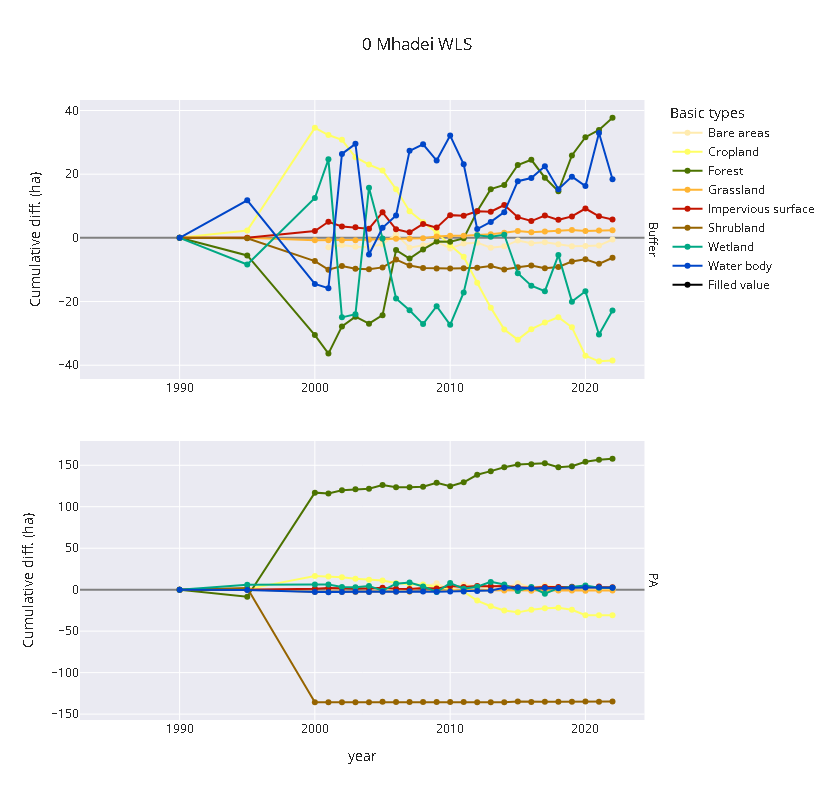

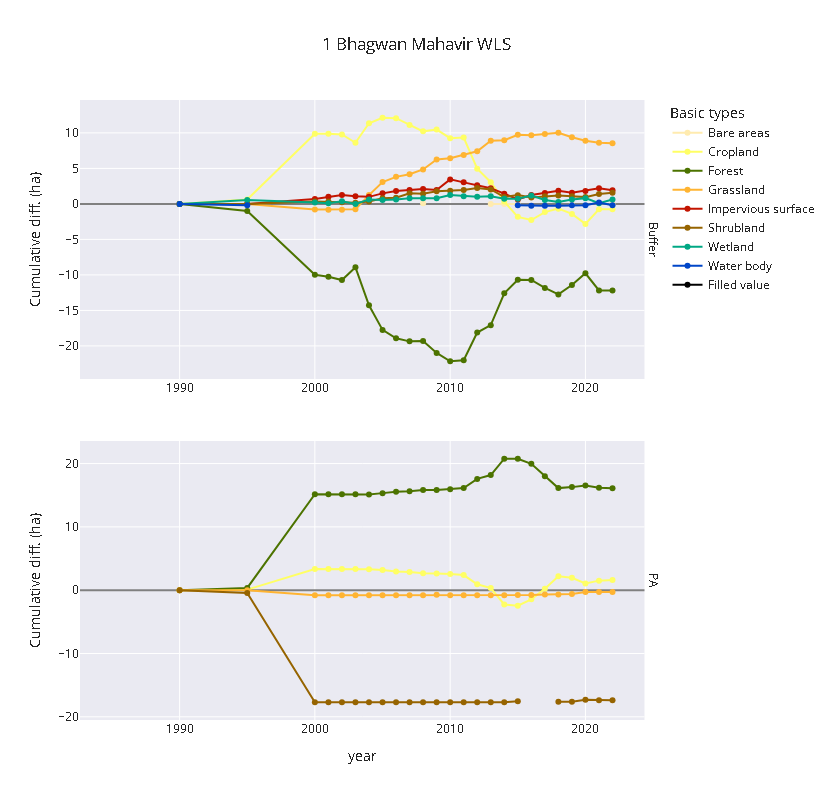

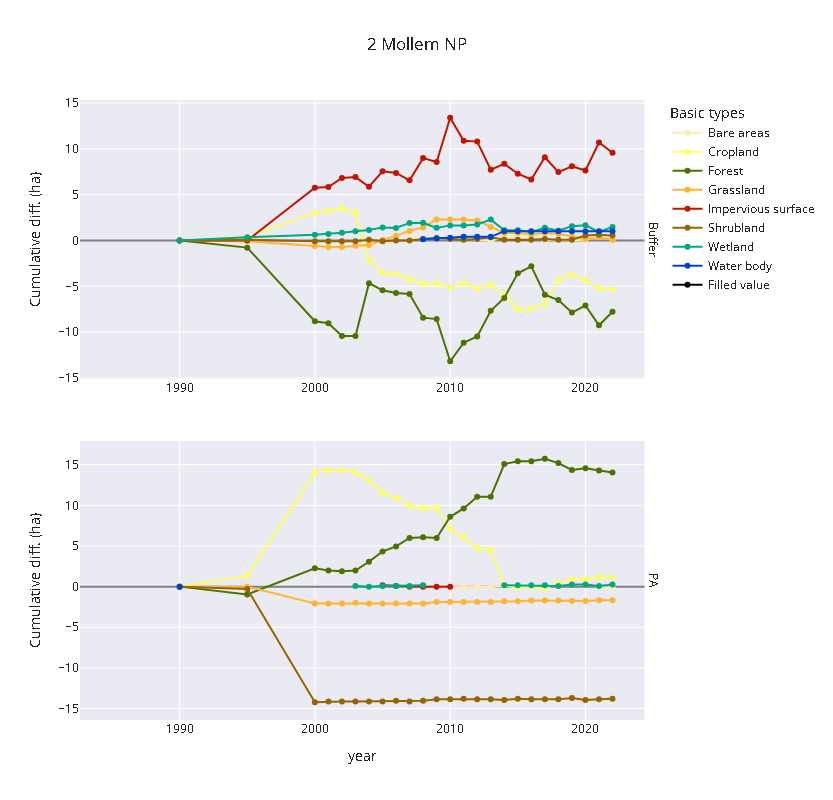

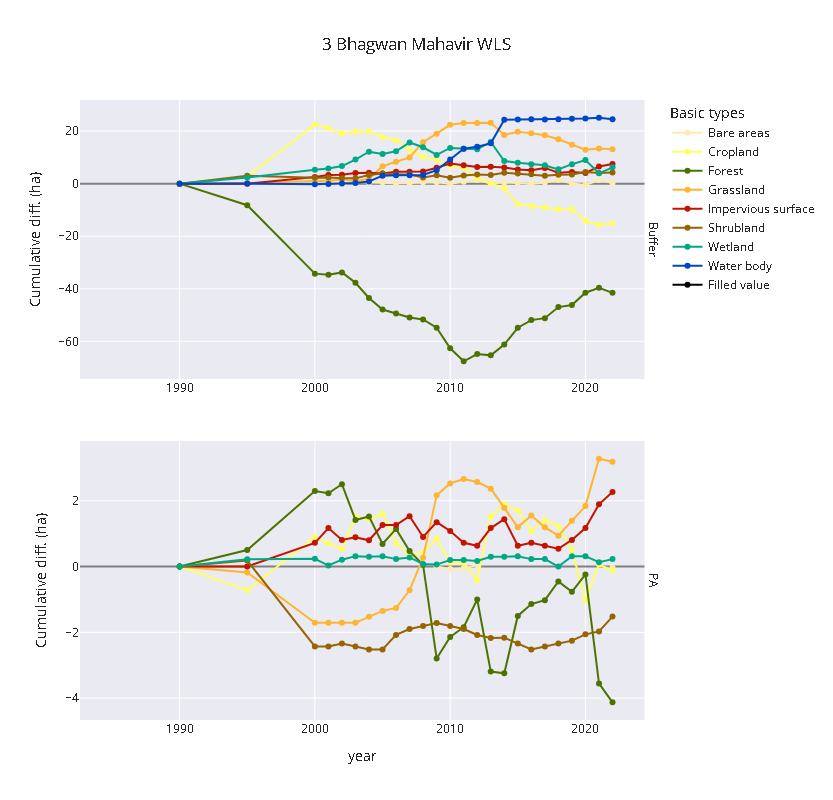

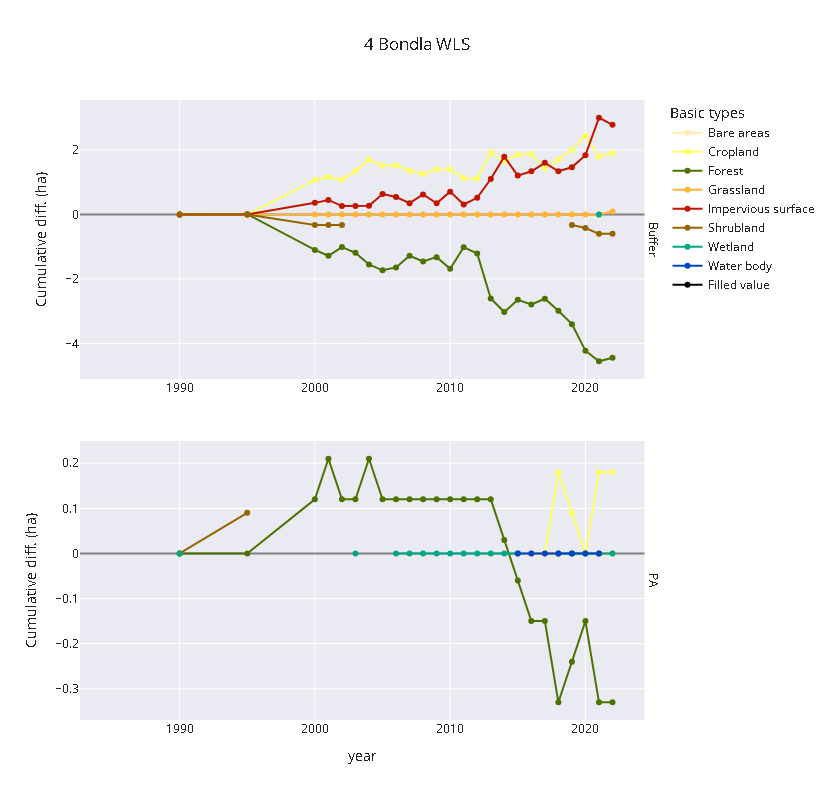

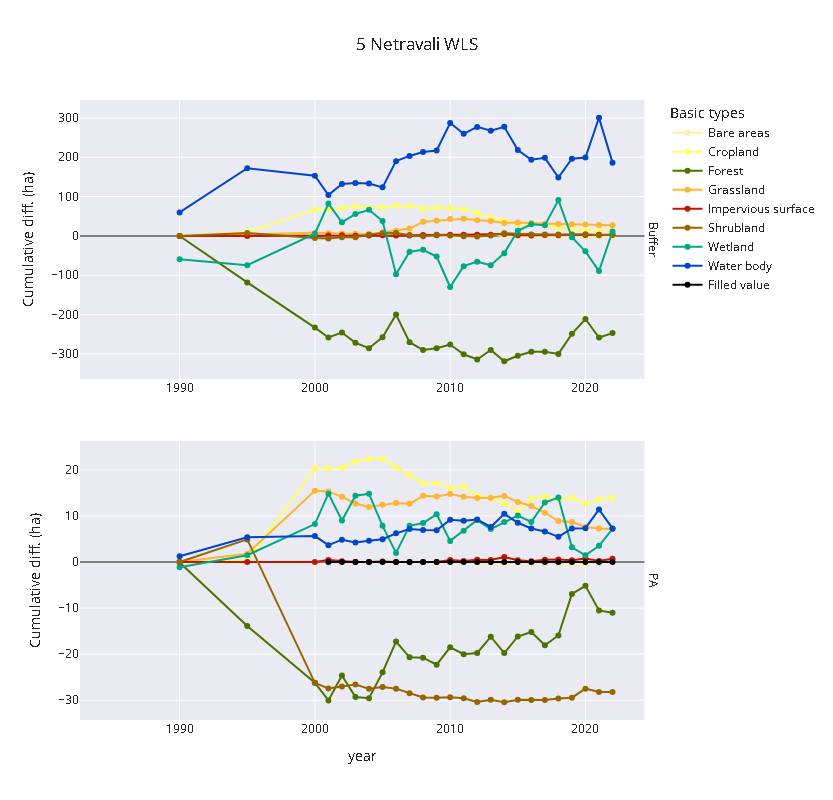

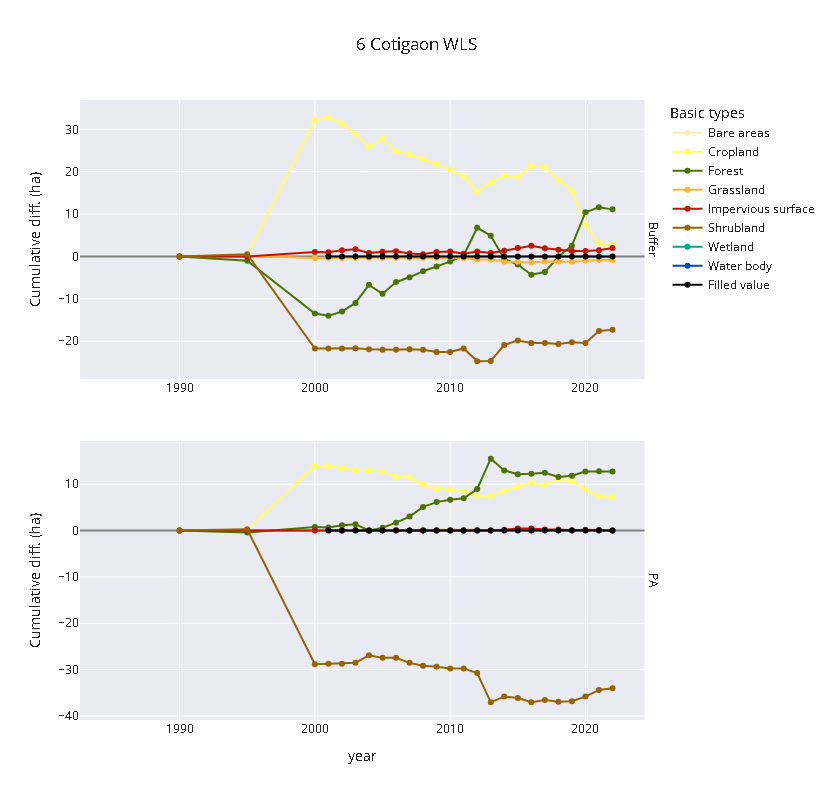

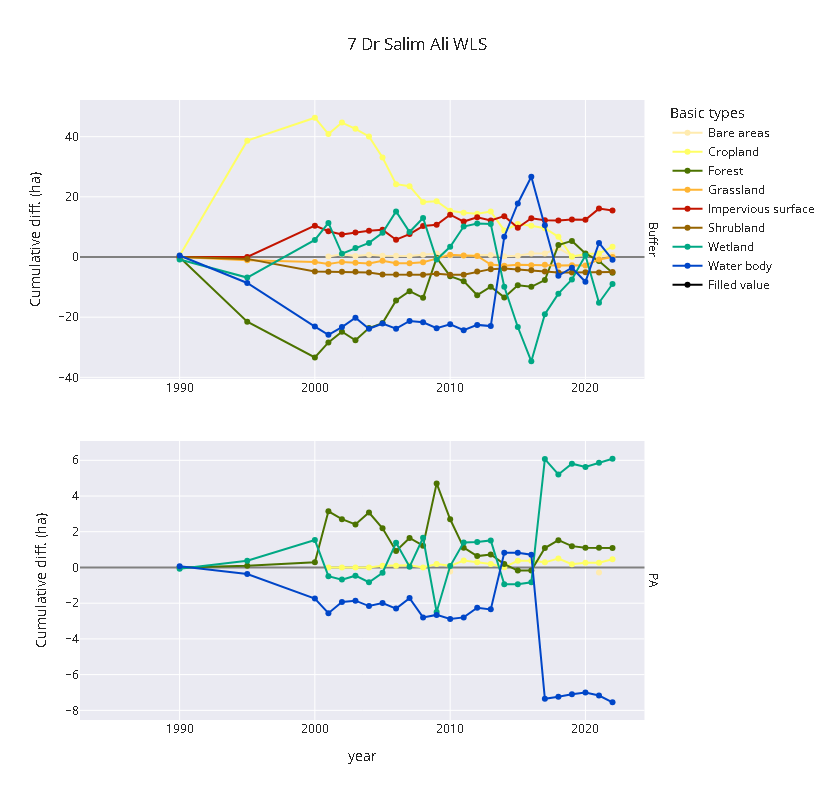

In [7]:
import plotly.express as px
pd.options.plotting.backend = "plotly"
# Read in the data
land_cover_area = pd.read_feather('feathers/land_cover_area.feather')
land_cover_types = pd.read_feather('feathers/GLC_FCS30D_landcover_types.feather')

# Aggregate the data along both axes
land_cover_area = land_cover_area.groupby(['esz', 'part', 'year']).sum(min_count=1)
land_cover_area = land_cover_area.T.groupby('basic_id').sum(min_count=1).T

# Convert sq. m to ha
land_cover_area /= 10000

# Get basic classification names and colours for graph legends
lc_names = land_cover_types.groupby('basic_id')['basic_classification_system'].first().to_dict()
lc_names['XXX'] = 'Filled value'

lc_colors = land_cover_types.groupby('basic_classification_system')['basic_color'].first().to_dict()
#lc_colors = {k : tuple([float(x)/255 for x in v]) for k, v in lc_colors.items()}
lc_colors['Filled value'] = (0.0, 0.0, 0.0)

# Get land cover type names
new_names = {k : v for k, v in lc_names.items() if k in land_cover_area.columns.to_list()}
land_cover_area = land_cover_area.rename(columns=new_names)

# Get land cover type colours
group_colors = {k : '#{:02x}{:02x}{:02x}'.format(int(v[0]), int(v[1]), int(v[2])) for k, v in lc_colors.items() if k in land_cover_area.columns.to_list()}

# Drop empty years
land_cover_area = land_cover_area.dropna(axis=0, how='all')

# Group by ESZ and part for individual plots
lc_area_diff_cumsum = land_cover_area.groupby(['esz', 'part'], as_index=False, group_keys=False).transform(lambda part: part.diff().cumsum())

# Loop over ESZ parts,
# plot their cummulative differences,
for name, group in lc_area_diff_cumsum.groupby('esz', as_index=False, group_keys=False):
    df = group.reset_index().drop(columns=['esz']).set_index('year')
    fig = px.line(
        data_frame=df,
        x=df.index,
        y=list(new_names.values()),
        color_discrete_map=group_colors,
        title=' '.join(name.split('_')),
        template='seaborn',
        facet_row=df['part'],
        labels={'index':'year', 'value':'Cumulative diff. (ha)', 'variable':'Basic types'},
        facet_row_spacing=0.1,
        height=800,
        markers=True)
    fig.update_yaxes(matches=None)
    fig.for_each_annotation(lambda a: a.update(text='Buffer' if 'buffer' in a.text else 'PA'))
    fig.for_each_yaxis(lambda y: y.update(showticklabels=True, matches=None, zeroline=True, zerolinewidth=2, zerolinecolor='grey'))
    fig.for_each_xaxis(lambda x: x.update(showticklabels=True, matches=None))
    fig.show()
    print()